Copyright Preferred Computational Chemistry, Inc. as contributors to Matlantis contrib project

# MD Li diffusion in LGPS - postprocess analysis

We analyze the MD result of LPGS Li diffusion in this script.

## Setup

In [1]:
# Please install these libraries only for first time of execution
!pip install pandas matplotlib scipy ase

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.matlantis-common.svc:8080/simple


In [2]:
import pathlib
EXAMPLE_DIR = pathlib.Path("__file__").resolve().parent
INPUT_DIR = EXAMPLE_DIR / "input"
OUTPUT_DIR = EXAMPLE_DIR / "output"

In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
import glob, os

import ase
from ase.visualize import view
from ase.io import read, write
from ase.io import Trajectory

## Analyze specific temperature

We read trajectory file with 20 step interval.

Since trajectory file is saved with 0.05 ps interval in the previous MD simulation, this `trj` is 1ps interval.

In [4]:
temp = 523
#temp = 423

trj = read(OUTPUT_DIR / f"traj_and_log/MD_{temp:04}.traj", index="::20")
view(trj, viewer = "ngl")

In [5]:
Li_index = [i for i, x in enumerate(trj[0].get_chemical_symbols()) if x == 'Li']
print(len(Li_index))

20


To calculate diffusion coefficient, we can calculate mean square displacement, variance of positions.

In [6]:
# t0 = len(trj) // 2
t0 = 0

positions_all = np.array([trj[i].get_positions() for i in range(t0, len(trj))])

# shape is (n_traj, n_atoms, 3 (xyz))
print("positions_all.shape: ", positions_all.shape)

# position of Li 
positions = positions_all[:, Li_index]
positions_x = positions[:, :, 0]
positions_y = positions[:, :, 1]
positions_z = positions[:, :, 2]

print("positions.shape    : ", positions.shape)
print("positions_x.shape  : ", positions_x.shape)

positions_all.shape:  (1001, 50, 3)
positions.shape    :  (1001, 20, 3)
positions_x.shape  :  (1001, 20)


In [8]:
# msd for each x,y,z axis
msd_x = np.mean((positions_x-positions_x[0])**2, axis=1)
msd_y = np.mean((positions_y-positions_y[0])**2, axis=1)
msd_z = np.mean((positions_z-positions_z[0])**2, axis=1)

# total msd. sum along xyz axis & mean along Li atoms axis.
msd = np.mean(np.sum((positions-positions[0])**2, axis=2), axis=1)

At first, we can see from the figure that diffusion is prominent along z-axis than x, y-axis, which matches the known fact.

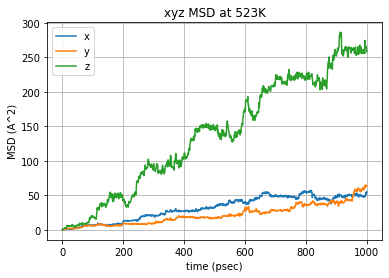

In [9]:
plt.plot(range(len(msd_x)), msd_x, label="x")
plt.plot(range(len(msd_y)), msd_y, label="y")
plt.plot(range(len(msd_z)), msd_z, label="z")
plt.grid(True)
#plt.xlim(0,100)
#plt.ylim(0,10)
plt.xlabel("time (psec)")
plt.ylabel("MSD (A^2)")
plt.title(f"xyz MSD at {temp}K")
plt.legend()
plt.show()

Next, we can fit line to the total msd to obtain diffusion coefficient.

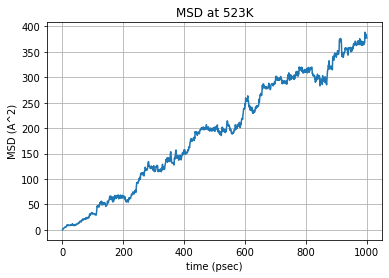

In [10]:
plt.plot(range(len(msd)), msd)
plt.grid(True)
#plt.xlim(0,100)
#plt.ylim(0,10)
plt.xlabel("time (psec)")
plt.ylabel("MSD (A^2)")
plt.title(f"MSD at {temp}K")
plt.show()

Here `scipy.stats.linregress` is used to fit straight line.
 - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html
 
The coefficient 6 comes from the degree of freedom in xyz-axis.

In [12]:
slope, intercept, r_value, _, _ = stats.linregress(range(len(msd)), msd)
D = slope / 6
print(slope, intercept, r_value)
print(f"Diffusion coefficient {D:.2f} A^2/psec")

0.38456536754706533 -0.44944835499697433 0.9922347360918651
Diffusion coefficient 0.06 A^2/psec


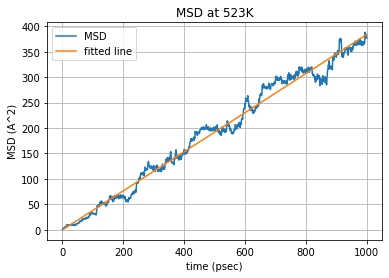

In [13]:
t = np.arange(len(msd))
#plt.scatter(t, msd, label="MSD")
plt.plot(t, msd, label="MSD")
plt.plot(t, t * slope + intercept, label="fitted line")
plt.grid(True)
plt.legend()
#plt.xlim(0,100)
#plt.ylim(0,10)
plt.xlabel("time (psec)")
plt.ylabel("MSD (A^2)")
plt.title(f"MSD at {temp}K")
plt.show()

Convert diffusion coefficient from A^2/ps to cm^2/sec unit, take log.

In [14]:
np.log10(D*1e-16*1e12)

-5.193181079582682

## Analyze temperature dependency

We can calculate activation energy $E_A$ from Arrhenius equation
 
$$D = D_0 \exp \left(- \frac{E_A}{RT} \right)$$

where $D$ is the diffusion coefficient at temperature $T$.

 - https://en.wikipedia.org/wiki/Arrhenius_equation

By taking log to each side, we obtain

$$\log D = \log D_0 - \frac{E_A}{RT}.$$

Thus when we plot $\log D$ as y-axis and $1/T$ as x-axis, we can calculate activation energy $E_A$ from the slope value.

We calculate diffusion coefficient for each temperature by following the same procedure in previous section.

In [15]:
trj_list = sorted(glob.glob(f"{OUTPUT_DIR}/traj_and_log/*.traj"))

In [16]:
trj_list

['/home/jovyan/MD_Li-diffusion_in_LGPS/output/traj_and_log/MD_0423.traj',
 '/home/jovyan/MD_Li-diffusion_in_LGPS/output/traj_and_log/MD_0523.traj',
 '/home/jovyan/MD_Li-diffusion_in_LGPS/output/traj_and_log/MD_0623.traj',
 '/home/jovyan/MD_Li-diffusion_in_LGPS/output/traj_and_log/MD_0723.traj',
 '/home/jovyan/MD_Li-diffusion_in_LGPS/output/traj_and_log/MD_0823.traj',
 '/home/jovyan/MD_Li-diffusion_in_LGPS/output/traj_and_log/MD_0923.traj',
 '/home/jovyan/MD_Li-diffusion_in_LGPS/output/traj_and_log/MD_0973.traj',
 '/home/jovyan/MD_Li-diffusion_in_LGPS/output/traj_and_log/MD_1023.traj']

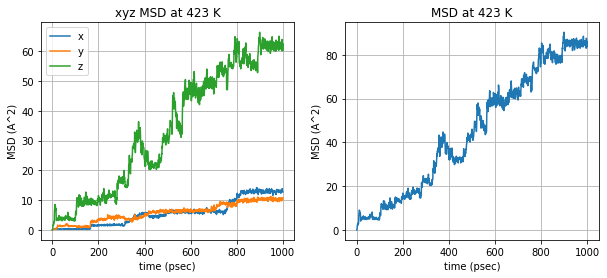

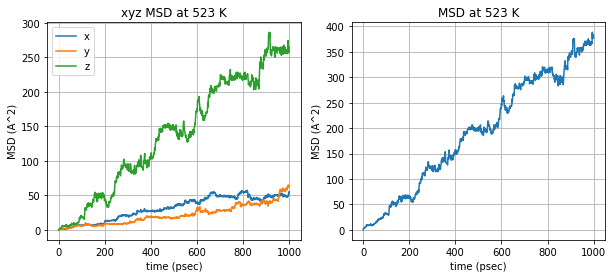

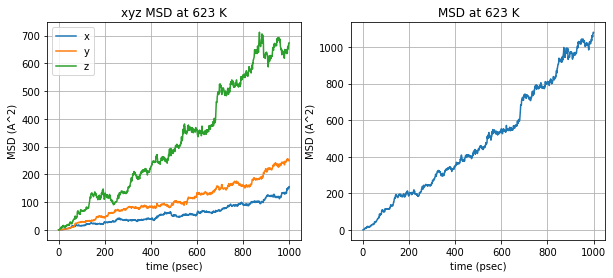

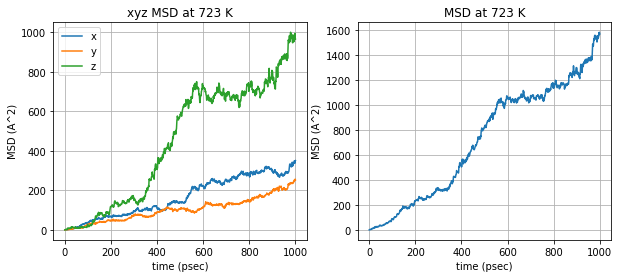

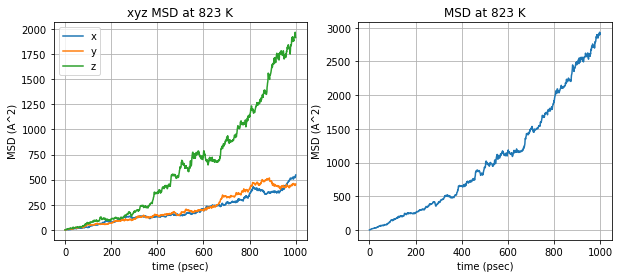

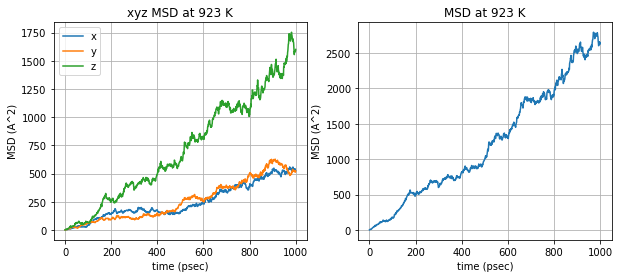

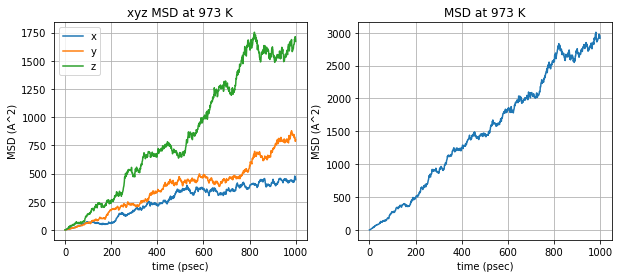

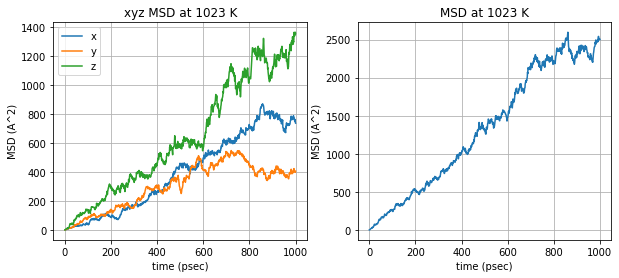

In [17]:
t0 = 0

os.makedirs(OUTPUT_DIR / "msd/", exist_ok=True)
D_list = []
for path in trj_list:
    trj = read(path, index="::20")
    Li_index = [Li_i for Li_i, x in enumerate(trj[0].get_chemical_symbols()) if x == 'Li']

    # msd for each x,y,z axis
    positions_all = np.array([trj[i].get_positions() for i in range(t0, len(trj))])
    positions = positions_all[:, Li_index]
    positions_x = positions[:, :, 0]
    positions_y = positions[:, :, 1]
    positions_z = positions[:, :, 2]
    # msd for each x,y,z axis
    msd_x = np.mean((positions_x-positions_x[0])**2, axis=1)
    msd_y = np.mean((positions_y-positions_y[0])**2, axis=1)
    msd_z = np.mean((positions_z-positions_z[0])**2, axis=1)

    # total msd. sum along xyz axis & mean along Li atoms axis.
    msd = np.mean(np.sum((positions-positions[0])**2, axis=2), axis=1)
    
    slope, intercept, r_value, _, _ = stats.linregress(range(len(msd)), msd)
    logD = np.log10(slope*1e-16*1e12/6)
    T = int(os.path.basename(path.split(".")[0].replace("MD_","").replace("traj_and_log/","")))
    D_list.append([T, 1000/T, logD])
    
    fig = plt.figure(figsize=(10,4), facecolor='w')
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(range(len(msd_x)), msd_x, label="x")
    ax1.plot(range(len(msd_y)), msd_y, label="y")
    ax1.plot(range(len(msd_z)), msd_z, label="z")
    ax1.set_xlabel("time (psec)")
    ax1.set_ylabel("MSD (A^2)")
    ax1.legend()
    ax1.set_title(f"xyz MSD at {T} K")
    ax1.grid(True)
    
    #fig = plt.figure()
    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(range(len(msd)), msd)
    ax2.set_xlabel("time (psec)")
    ax2.set_ylabel("MSD (A^2)")
    ax2.set_title(f"MSD at {T} K")
    ax2.grid(True)

    plt.show(fig)
    fig.savefig(path.replace("traj_and_log/", "msd/").replace("traj", "png"))
    plt.close(fig)

In [18]:
df = pd.DataFrame(D_list, columns=["T", "1000/T", "logD"])

In [19]:
df

,T,1000/T,logD
0,423,2.364066,-5.802397
1,523,1.912046,-5.193181
2,623,1.605136,-4.756214
3,723,1.383126,-4.583190
4,823,1.215067,-4.332002
5,923,1.083424,-4.343488
6,973,1.027749,-4.290990
7,1023,0.977517,-4.341426


In [20]:
sl, ic, rv, _, _ = stats.linregress(df["1000/T"], df["logD"])
print(sl, ic, rv)

-1.0856951904952106 -3.1354278416677452 -0.9834568664784172


Arrhenius plot, following the reference
 - [First Principles Study of the Li10GeP2S12 Lithium Super Ionic Conductor Material](https://pubs.acs.org/doi/10.1021/cm203303y)

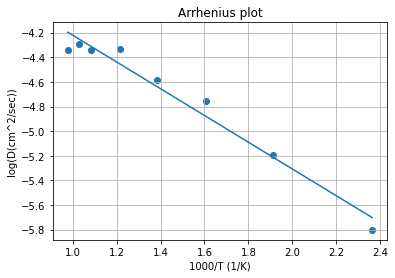

In [21]:
fig = plt.figure()
plt.scatter(df["1000/T"], df["logD"])
plt.plot(df["1000/T"], df["1000/T"]*sl+ic)

plt.grid(True)
plt.xlabel("1000/T (1/K)")
plt.ylabel("log(D(cm^2/sec))")
plt.title("Arrhenius plot")
fig.savefig(OUTPUT_DIR / "arrhenius_plot.png")

Finally we can calculate activation energy from the arrhenius plot.

Below, the term `1000 * np.log(10)` is to fix the x, y-axis scale.

In [22]:
from ase.units import J, mol
R = 8.31446261815324  # J/(K・mol)


E_act = -sl * 1000 * np.log(10) * R * (J / mol)
print(f"Activation energy: {E_act* 1000:.1f} meV")

Activation energy: 215.4 meV
